# Underactuated cartpole control with iLQR, MPPI
This example shows model predictive control to swing up the underactuated cartpole.

![Underactuated cartpole control with iLQR](./cartpole-ilqr.gif)

## Problem

**Model.** The "cartpole" is a free pendulum on a linear cart.  The input to the system is a force on the cart $f$.

$$
m l \ddot{p} \cos(\theta) + m l^2 \ddot{\theta} - m g l \sin(\theta) = 0 \\
(m + m_c) \ddot{p} + m l \ddot{\theta} \cos(\theta) - m l \dot{\theta}^2 \sin(\theta) = f
$$
where $\theta = 0$ is the angle of the pendulum when completely upright, and $p$ is the position of the cart.  The state of the system is $x = (p, \theta, \dot{p}, \dot{\theta})^\top$.  Parameters are the mass of the pendulum at the tip $m = 0.15$ kg, length of the pendulum $l = 0.75$ m, acceleration due to gravity $g = 9.8$ m/s , and the mass of the cart $m_c=1$ kg.

**Control.** The objective is to move the cart so that the pendulum will stand up vertically.  This is a classic controls and RL problem and is a typical benchmark test for new algorithms.  We use the quadratic cost function

$$
J = \sum_{i=1}^{N} x_i^\top Q x_i + \sum_{i=1}^{N-1} r u_i^2
$$

where $Q = \text{diag}(1.25, 1, 12, 0.25)$ is chosen to drive the system states 0, and the penalty $r = 0.01$ tradeoffs the input magnitude.

**Comparison to MPPI.**  The video above shows iLQR which works well for this problem.  Examining MPPI (sampling-based control) in the video below, the algorithm seems to find a control that achieves the desired swing up behavior and temporarily stabilizes the system, however if the algorithm is left to run long enough, the system destabilizes and the controller is unable to maintain the upright posture.  This is believed due to a deficiency in the sampling approach as the noise in the control is amplified to attempt to maintain stability.

![Underactuated cartpole control with MPPI](./cartpole-mppi.gif)

## Example

To run the example, build and install the C++ and Python libraries from the main README instructions.  Start the docker container.
```
# Run the experiment
cd /libsia/bin
./example-cartpole --datafile /libsia/data/cartpole.csv --algorithm ilqr

# Run the python script
cd /libsia/examples/cartpole
python cartpole.py --help
python cartpole.py --datafile /libsia/data/cartpole.csv
```

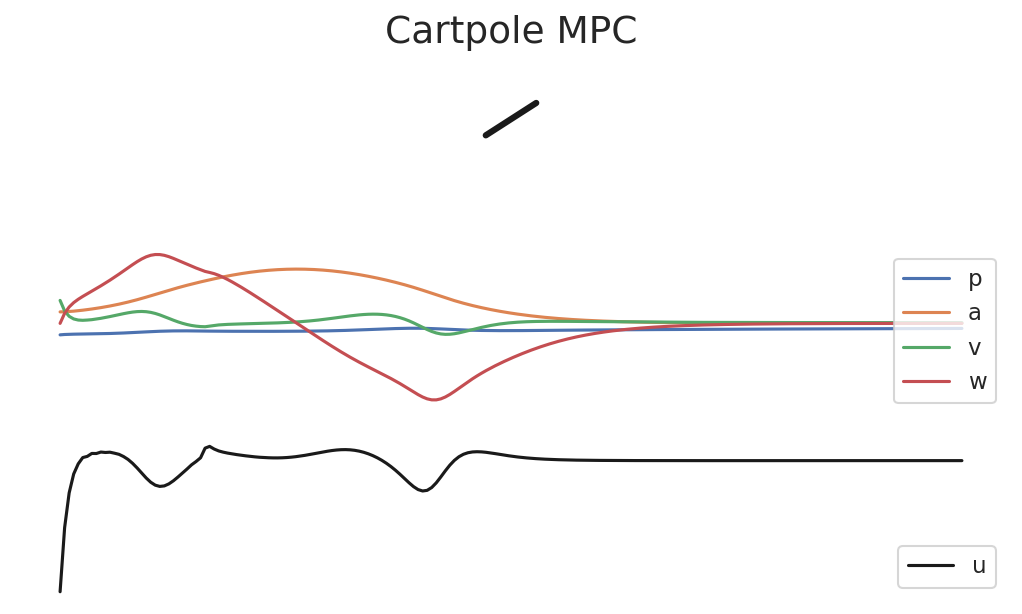

In [1]:
# This example imports data generated by the executable
from cartpole import plot_cartpole_trajectory

# This is the same as running the python script
plot_cartpole_trajectory(datafile="/libsia/data/cartpole.csv",
                         animate=True,
                         trace=False,
                         video_name="cartpole-animated.mp4",
                         dpi=150,
                         fps=30,
                         clean_axes=True)